#Initial Data Analysis of Diabetes DataSet

intialsing spark session

In [0]:
!pip install pyspark==3.1.2 --user
!pip install findspark --user

In [0]:
import findspark
findspark.init()

In [0]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [0]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

import required libraries

In [0]:
from pyspark.sql.functions import col, sum,countDistinct,when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


Loading Dataset fom CSV file to Spark DataFrame

In [0]:
path = "dbfs:/FileStore/tables/diabetes.csv"
df = spark.read.csv(path,header=True,inferSchema=True)
df.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|         0.0|     0|     1.0|        1|15.0|   1.0|   0.0|                 0.0|           0|     1|      1|                0|            1|        0.0|    5.0|    10.0|    20.0|     0.0|  0| 11|      4.0|   5.0|
|         2.0|     1|     0.0|        1|28.0|   0.0|   0.0|                 1.0|           0|     1|      0|                0|            1|        

In [0]:
# Create a view or table

temp_table_name = "diabetes"

df.createOrReplaceTempView(temp_table_name)

Check Datatypes of the columns in DataFrame

In [0]:
df.printSchema()

root
 |-- Diabetes_012: double (nullable = true)
 |-- HighBP: integer (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Veggies: integer (nullable = true)
 |-- HvyAlcoholConsump: integer (nullable = true)
 |-- AnyHealthcare: integer (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [0]:
%sql
SELECT 
    CholCheck,
    HighChol,
    COUNT(*)  as Count
 FROM diabetes
GROUP by
    CholCheck,
    HighChol
Order BY CholCheck


CholCheck,HighChol,Count
0,0.0,7327
0,1.0,1337
1,0.0,134013
1,1.0,93701


Chek for null values

In [0]:

def summary(df):
    summary_df = pd.DataFrame([(c, t) for c, t in df.dtypes], columns=['columnName', 'dtypes'])
    
    # Display null counts for each column
    null_counts = [df.select([sum(col(c).isNull().cast('int')).alias(c + '_null_count')]).first()[0] for c in summary_df['columnName']]
    summary_df['missing'] = null_counts
    
    # Display unique counts for each column
    unique_counts = [df.select(countDistinct(c).alias(c + '_unique_count')).first()[0] for c in summary_df['columnName']]
    summary_df['unique'] = unique_counts
    
    return summary_df

# Show the result
summary_df = summary(df)

In [0]:
summary_df

,columnName,dtypes,missing,unique
0,Diabetes_012,double,0,3
1,HighBP,int,0,2
2,HighChol,double,0,2
3,CholCheck,int,0,2
4,BMI,double,0,84
5,Smoker,double,0,2
6,Stroke,double,0,2
7,HeartDiseaseorAttack,double,0,2
8,PhysActivity,int,0,2
9,Fruits,int,0,2


According to https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf BMI, MentHlth,PhyHlth are not Categorical varables while others are ctegorical variables. Therfore, they will seperate ito categories when we come to feature engineering section. There are no null values in this dataset


Importing plotting libraries

Create piechart of sample chosen from dataset to identify precentages of population with and without diabetes

In [0]:
def getSampleforPie(df , spark):

    double_tuple_rdd = spark.sql("""
        select Diabetes_012,COUNT(*) AS COUNT from diabetes GROUP BY Diabetes_012 order by Diabetes_012 asc
    """).rdd.map(lambda row : (row.Diabetes_012,row.COUNT))
    result_array_Diabetes = double_tuple_rdd.map(lambda Diabetes_012_COUNT: Diabetes_012_COUNT[0]).collect()
    result_array_Count = double_tuple_rdd.map(lambda Diabetes_012_COUNT: Diabetes_012_COUNT[1]).collect()
    return (result_array_Diabetes,result_array_Count)

([<matplotlib.patches.Wedge at 0x7f352a9f6980>,
 [Text(-0.5473475207052068, -0.9541544380119308, 'No Diabetes'),
  Text(0.9054757832618996, 0.6245907507530429, 'Pre-Diabetes'),
  Text(0.4746323365172917, 0.992332678657786, 'Diabetes')],
 [Text(-0.2985531931119309, -0.5204478752792349, '83.4%'),
  Text(0.4938958817792179, 0.34068586404711426, '2.4%'),
  Text(0.25889036537306814, 0.541272370176974, '14.2%')])

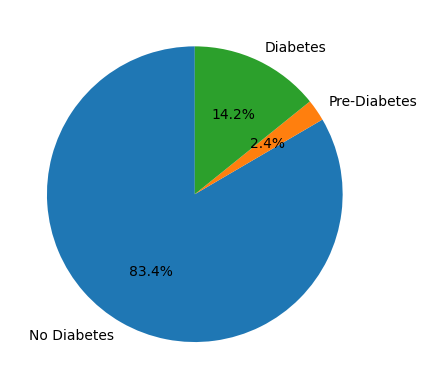

In [0]:
plt.pie(getSampleforPie(df , spark)[1],labels=['No Diabetes','Pre-Diabetes','Diabetes'],autopct='%1.1f%%',startangle=90)

83.4% of population dont having diabetes and only 14.2% have diabetes. 2.4% is at margin. It seems it is skewd data set. Also, If someone choose from population there in 83.4% chance that person don't have diabetes. We should conisder this when we set minimum accuracy level for a machine learning model.

## Basic Statistics

Functions to calculate Mean,Standard devation., Skewness and Kurtosis of each column in Dataset

In [0]:
def meanColumn(spark, df, column_name):
    return spark.sql("SELECT AVG({}) as mean_value FROM diabetes".format(column_name)).first().mean_value

def stdColumn(spark, df, column_name):
    return spark.sql("SELECT STDDEV({}) as stddev_value FROM diabetes".format(column_name)).first().stddev_value

def skewColumn(spark, df, column_name):
    return spark.sql("""
        SELECT
            (
                1/COUNT(*)
            ) *
            SUM (
                POWER({}-{},3)/POWER({},3)
            ) as skcolumn
        FROM diabetes
    """.format(column_name, meanColumn(spark, df, column_name), stdColumn(spark, df, column_name))).first().skcolumn

def kurColumn(spark, df, column_name):
    return spark.sql("""
        SELECT
            (
                1/COUNT(*)
            ) *
            SUM (
                POWER({}-{},4)/POWER({},4)
            ) as kurcolumn
        FROM diabetes
    """.format(column_name, meanColumn(spark, df, column_name), stdColumn(spark, df, column_name))).first().kurcolumn



Standard Deviation

In [0]:
def statmeasures(spark,df):
    columns = df.columns
    mean=[]
    std=[]
    skew =[]
    kurto =[]

    for column_name in columns:
        mean.append( meanColumn(spark, df, column_name))
        std.append(stdColumn(spark, df, column_name))
        skew.append(skewColumn(spark, df, column_name))
        kurto.append(kurColumn(spark, df, column_name))
    
    result_df = pd.DataFrame({'Column':columns,'Mean':mean,'Standard Deviation':std,'Skewness':skew,'Kurtosis':kurto})

    return result_df

statmeasures(spark,df)


,Column,Mean,Standard Deviation,Skewness,Kurtosis
0,Diabetes_012,0.307791,0.705037,1.916650,4.765269
1,HighBP,0.418558,0.493324,0.330174,1.109007
2,HighChol,0.402059,0.490315,0.399499,1.159592
3,CholCheck,0.963347,0.187909,-4.931584,25.320613
4,BMI,28.953579,6.552055,1.359193,7.095077
5,Smoker,0.411997,0.492196,0.357593,1.127865
6,Stroke,0.038900,0.193356,4.769425,23.747505
7,HeartDiseaseorAttack,0.086548,0.281172,2.940909,9.648973
8,PhysActivity,0.779231,0.414766,-1.346443,2.812909
9,Fruits,0.621259,0.485074,-0.499959,1.249952


From these measure we can get initial insight about data such as how values are distributed. 
Ex. BMI value centerlize on 28.96 and it has standerd deviation of 6.55. And it is positive skewed distribution. Also Kurtosis tells about outliers

### Colleration
Colleration can tells how columns collerated to each other

In [0]:
def correlation(spark, df, col1, col2):
    return spark.sql("SELECT CORR({}, {}) as correlation_col1_col2 FROM diabetes".format(col1, col2)).first().correlation_col1_col2

def correlation_df(spark, df):
    columns = df.columns[1:]
    corr_df = pd.DataFrame(index=columns, columns=columns)

    for i in range(len(columns)):
        for j in range(len(columns)):
            corr_df.iloc[i, j] = correlation(spark, df, columns[i], columns[j])

    return corr_df

corr_df = correlation_df(spark, df)
corr_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
HighBP,1.0,0.283285,0.099415,0.213951,0.09957,0.126594,0.203191,-0.132253,-0.031542,-0.036013,-0.003424,0.049833,-0.007477,0.281555,0.011743,0.140946,0.208262,0.067557,0.34539,-0.106342,-0.150292
HighChol,0.283285,1.0,0.098558,0.087188,0.082402,0.085947,0.170668,-0.076648,-0.024408,-0.031931,-0.014275,0.056505,-0.012307,0.187101,0.019851,0.104846,0.127667,0.029081,0.287937,-0.035434,-0.068196
CholCheck,0.099415,0.098558,1.0,0.036226,-0.012874,0.025386,0.043867,-0.008454,0.024951,0.017397,-0.028933,0.15464,-0.071406,0.042176,-0.01556,0.031339,0.044966,-0.048143,0.102707,0.030341,0.021765
BMI,0.213951,0.087188,0.036226,1.0,0.016289,0.010241,0.039518,-0.163979,-0.089897,-0.0479,-0.032644,-0.009609,0.048165,0.254835,0.088455,0.120976,0.199165,0.007928,-0.050161,-0.098964,-0.102487
Smoker,0.09957,0.082402,-0.012874,0.016289,1.0,0.057064,0.111283,-0.093729,-0.071277,-0.016522,0.098949,-0.023686,0.046932,0.166432,0.084626,0.113428,0.12364,0.073719,0.123354,-0.178179,-0.148127
Stroke,0.126594,0.085947,0.025386,0.010241,0.057064,1.0,0.177667,-0.078759,-0.000428,-0.024646,-0.013768,0.015463,0.021849,0.159723,0.045176,0.131955,0.162562,0.001288,0.128892,-0.061672,-0.115004
HeartDiseaseorAttack,0.203191,0.170668,0.043867,0.039518,0.111283,0.177667,1.0,-0.09771,-0.006846,-0.024645,-0.028314,0.025104,0.014479,0.239646,0.03466,0.170468,0.194299,0.085596,0.223501,-0.080808,-0.12474
PhysActivity,-0.132253,-0.076648,-0.008454,-0.163979,-0.093729,-0.078759,-0.09771,1.0,0.118245,0.136527,0.014532,0.024926,-0.0501,-0.284207,-0.116034,-0.248385,-0.284294,0.058629,-0.119369,0.211932,0.239828
Fruits,-0.031542,-0.024408,0.024951,-0.089897,-0.071277,-0.000428,-0.006846,0.118245,1.0,0.215982,-0.042936,0.019495,-0.029629,-0.082256,-0.058411,-0.032673,-0.029691,-0.053992,0.071838,0.087289,0.053229
Veggies,-0.036013,-0.031931,0.017397,-0.0479,-0.016522,-0.024646,-0.024645,0.136527,0.215982,1.0,0.018504,0.033485,-0.029406,-0.106095,-0.044501,-0.058647,-0.067165,-0.046652,0.003812,0.129723,0.138922


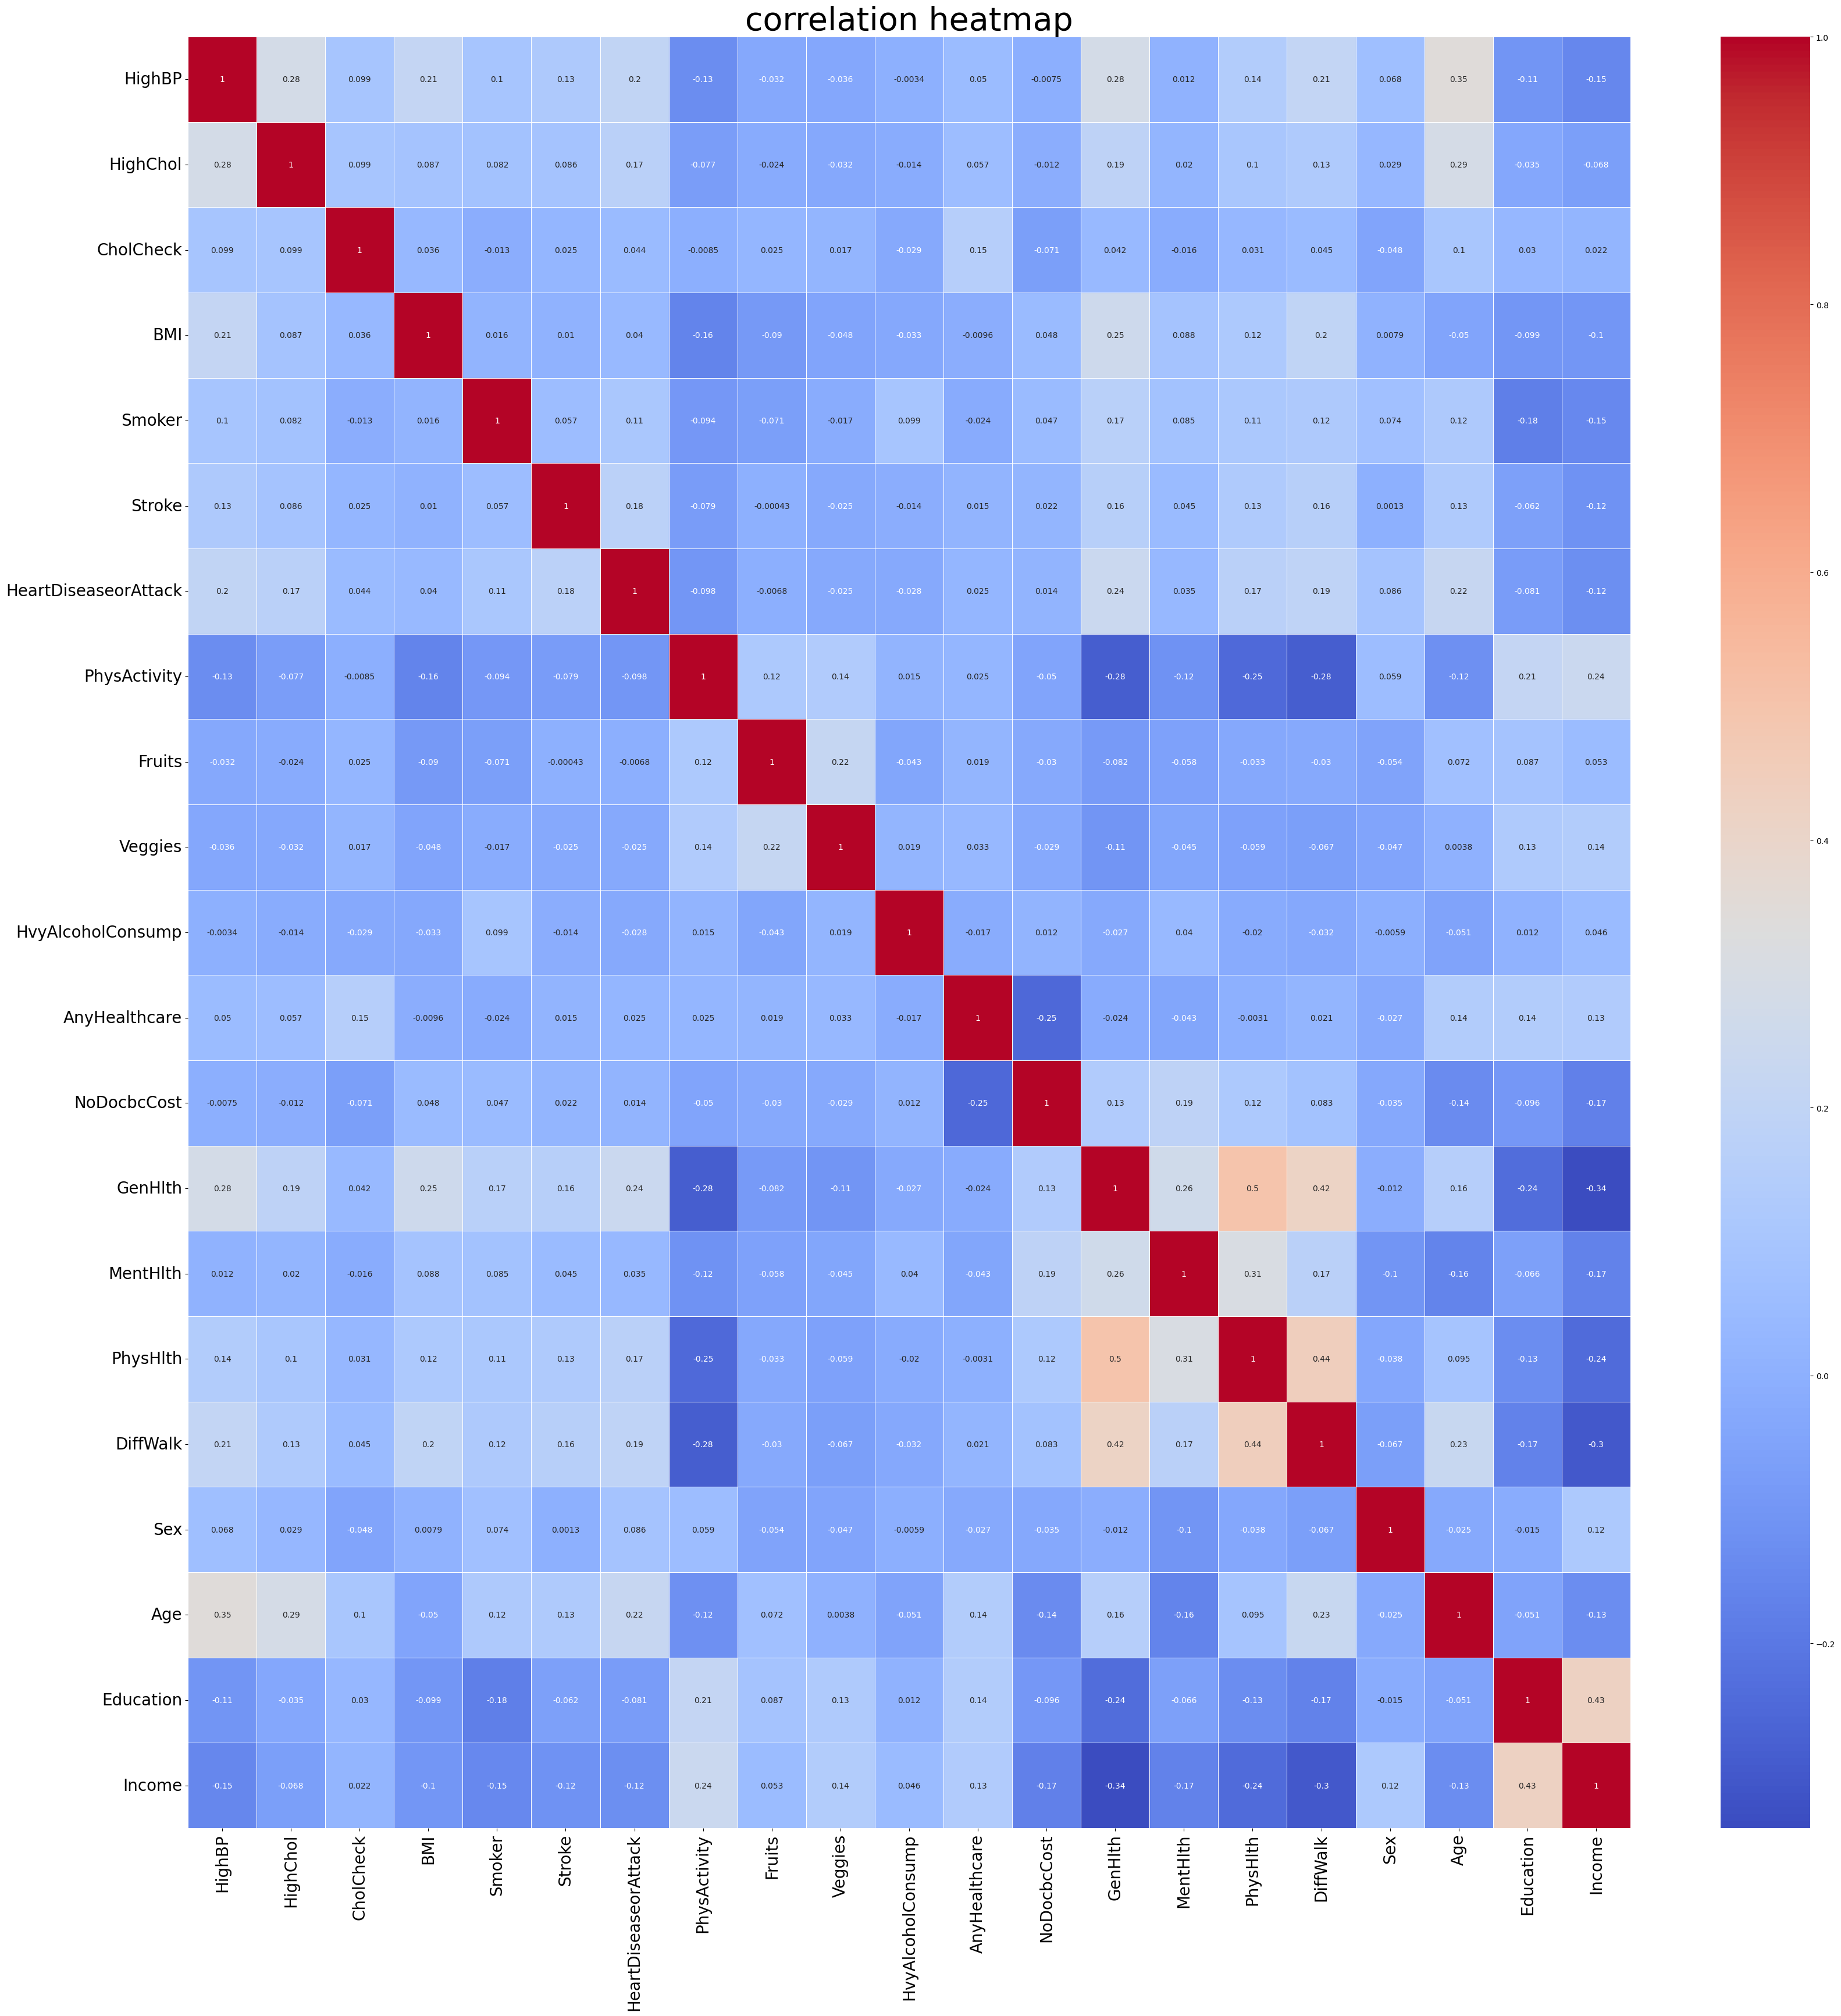

In [0]:
corr_df  = corr_df.apply(pd.to_numeric,errors='coerce')
plt.figure(figsize=(40,40))
sns.heatmap(corr_df,annot=True,cmap='coolwarm',linewidth=0.5)
plt.title("correlation heatmap",fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20,rotation=0)
plt.show()

It seems feartures are not much correlated to each other. However Physical heath, different to walk have some positive correlation to General health, and Heavy alchol consumption anf Income have negetive correlation to General health. Heavy alchol consuming have negative consumption to Physical health and Difficult to walk also. Income have negative corrrelation to Education level. Physical activity have negative correlation with physical health, difficult to walk and General health. But those correlations are in between -03 and 0.5. Dimension will reduce when we apply PCA t features.

Correlation of features to diabetics


## Analysis on Features using visuallizations and Statistics

First function was crated to count rows grouped by teo columns and perform chi squred test. 

In [0]:

def col2s_count(spark,diabetes,col1,col2):
    query = f"""
        SELECT 
            {col1},
            {col2},
            COUNT(*) as count
        FROM {diabetes}
        GROUP BY {col1}, {col2}
        ORDER BY {col1}
    """
    
    # Execute the query
    return spark.sql(query).toPandas()


In [0]:
def chi_squared_values_sql(spark, diabetes, col1, col2):
    # resut from the query
    counts = col2s_count(spark,diabetes,col1,col2)

    con_table = counts.pivot(index=col1, columns=col2, values='count').fillna(0)

    chi2, p, _, _ = chi2_contingency(con_table)

    return p

Then bar plots, box plots are used to visulize data . If features is categorical bar charts are used. If feature is continues box plots are used. Also, chi-squre test in some cases.

Text(0, 0.5, '')

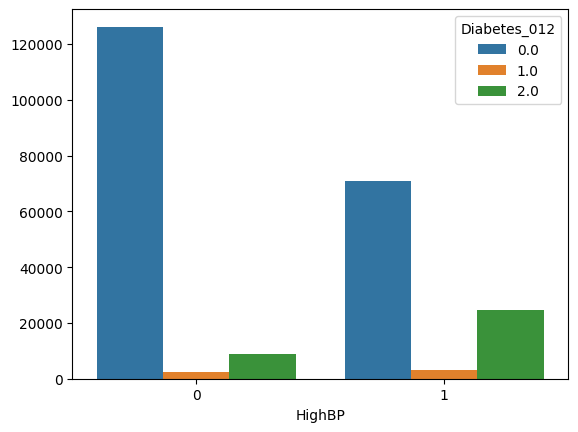

In [0]:

sns.barplot(x='HighBP',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','HighBP'))
plt.ylabel('')

it shows if persons with have high blood Pessure have more trend to have diabetics

<AxesSubplot:xlabel='HighChol', ylabel='count'>

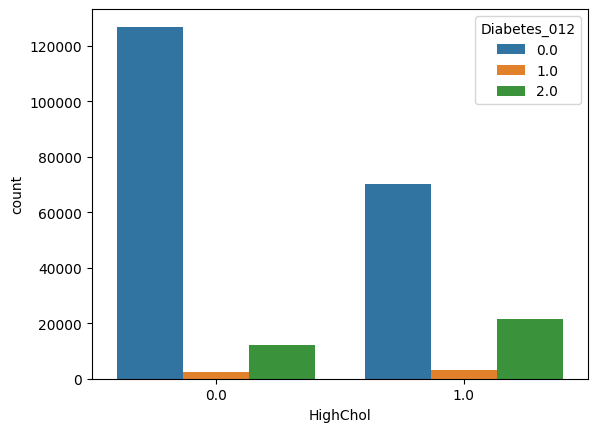

In [0]:
sns.barplot(x='HighChol',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','HighChol'))

it shows if persons with have high Cholestorl level have more trend to have diabetics

<AxesSubplot:xlabel='CholCheck', ylabel='count'>

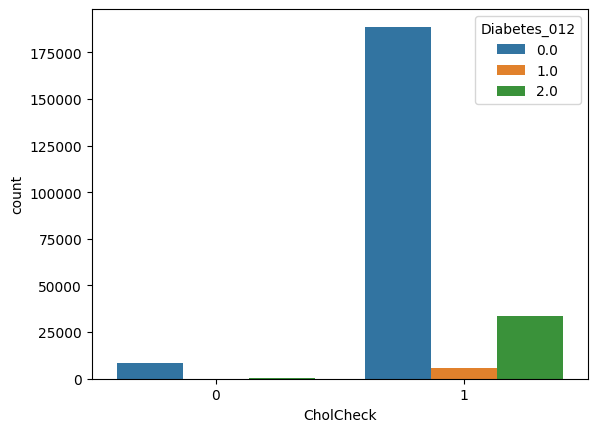

In [0]:
sns.barplot(x='CholCheck',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','CholCheck'))

There are morepersons who get Cholertorl test in during last five yers (if he/she diabetic person or not)

<AxesSubplot:xlabel='CholCheck', ylabel='count'>

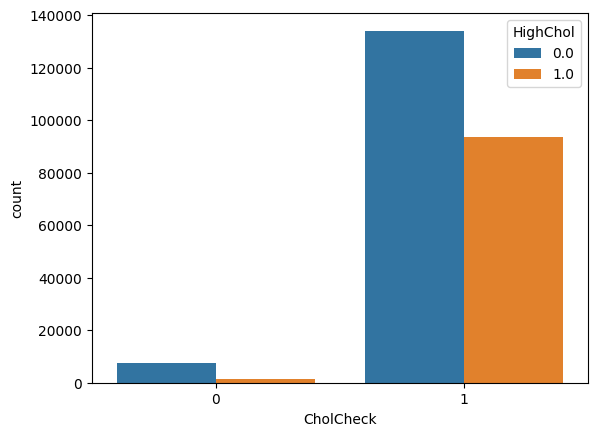

In [0]:
sns.barplot(x='CholCheck',y='count',hue='HighChol',data=col2s_count(spark,'diabetes','HighChol','CholCheck'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','CholCheck')

1.3265205678550773e-272

In [0]:
P value not exceed 0.5. Therefore Diabets may have dependency on Checking Cholestrol level

<AxesSubplot:xlabel='Diabetes_012', ylabel='BMI'>

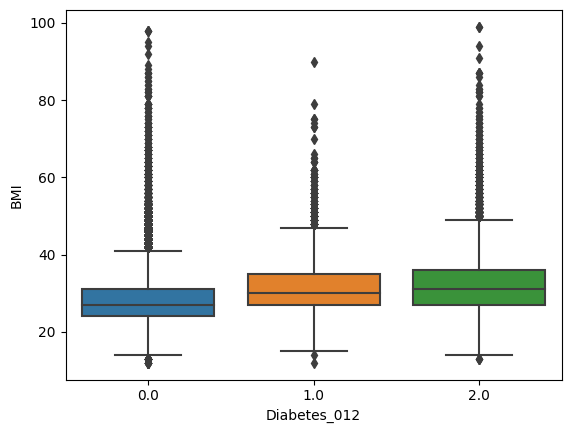

In [0]:
sns.boxplot(x = 'Diabetes_012',y='BMI',data=df.toPandas())

Persons who have hgiher BMI value have high chance for get diabetics

<AxesSubplot:xlabel='Smoker', ylabel='count'>

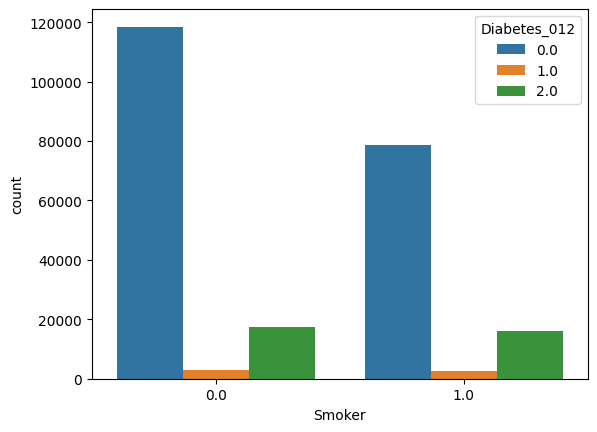

In [0]:
sns.barplot(x='Smoker',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Smoker'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','Smoker')

3.518246102327492e-179

In [0]:
p value form chi square is very small. Therefore, Smoking have effect on getting Diabetics

<AxesSubplot:xlabel='Stroke', ylabel='count'>

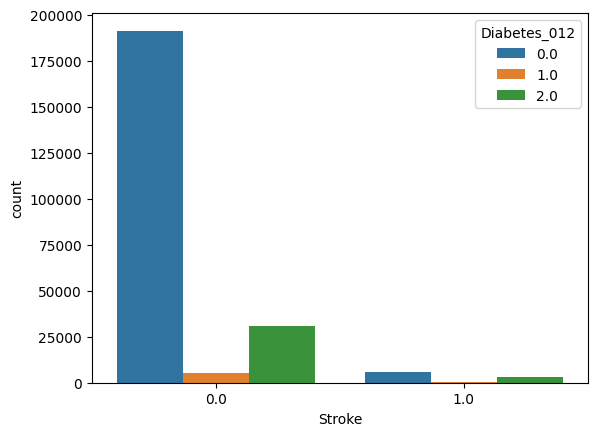

In [0]:
sns.barplot(x='Stroke',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Stroke'))

There are many people never diagnosed with a stroke. But form eye viwe it cal tell fraction of diabetic people in stroke category is higher than non-stroke category. Let's clarify there is depedency between diabetics and stroke chi-square test

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','Stroke')

0.0

<AxesSubplot:xlabel='HeartDiseaseorAttack', ylabel='count'>

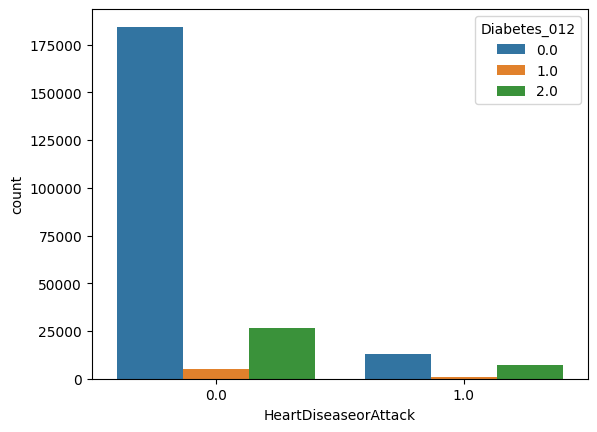

In [0]:
sns.barplot(x='HeartDiseaseorAttack',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','HeartDiseaseorAttack'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','HeartDiseaseorAttack')

0.0

In [0]:
Diabetics is depend on Heart Diesease or attacks

<AxesSubplot:xlabel='PhysActivity', ylabel='count'>

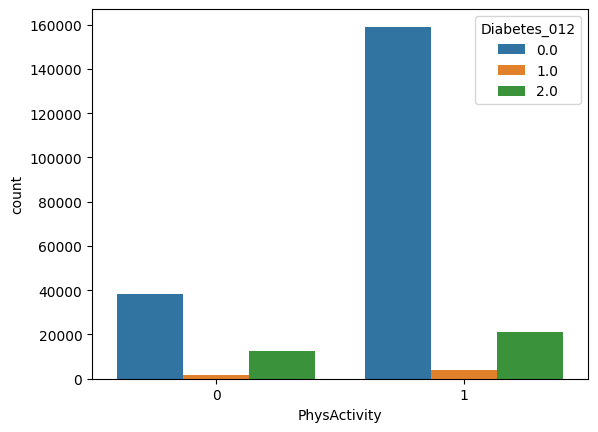

In [0]:
sns.barplot(x='PhysActivity',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','PhysActivity'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','PhysActivity')

0.0

In [0]:
Physical Activity also have high dependency on Diabetics

<AxesSubplot:xlabel='Fruits', ylabel='count'>

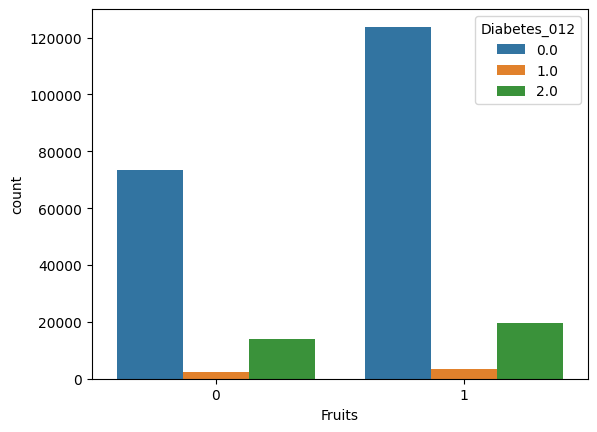

In [0]:
sns.barplot(x='Fruits',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Fruits'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','Fruits')

1.0099662525686564e-49

Get atleast one friut also have dependency on Diabetics

<AxesSubplot:xlabel='Veggies', ylabel='count'>

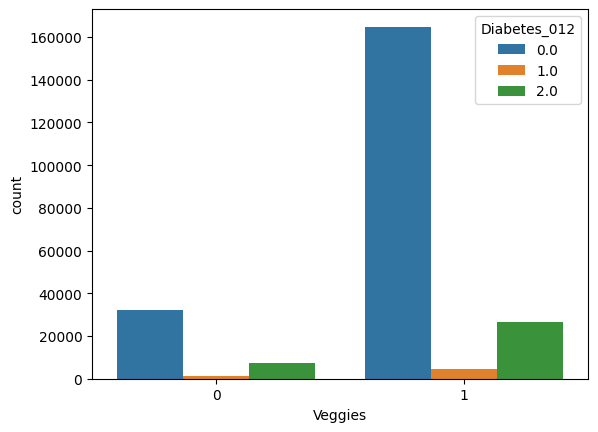

In [0]:
sns.barplot(x='Veggies',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Veggies'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','Veggies')

8.819373997048729e-119

In [0]:
Diabetic may depend of veggie factor also

<AxesSubplot:xlabel='AnyHealthcare', ylabel='count'>

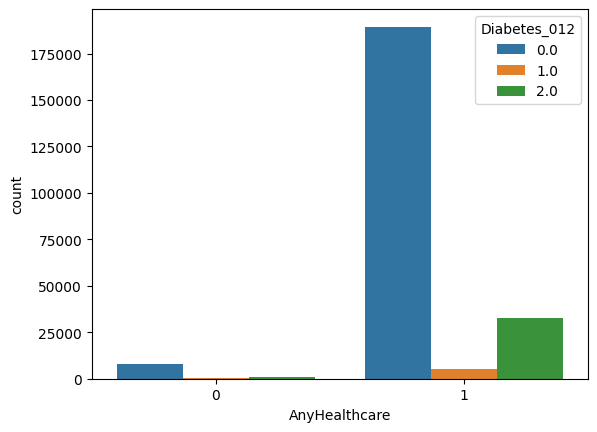

In [0]:
sns.barplot(x='AnyHealthcare',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','AnyHealthcare'))

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','AnyHealthcare')

1.6785960668071268e-40

According to calculation, If someone have any healthcare or not it is factor to have diabetics or not. But according to my understanding having a healthcare insurance may not be factor to diabetics. Also, diabetic may be the independent variable and Health Insuarance nmay be dependent variable. 

<AxesSubplot:xlabel='HvyAlcoholConsump', ylabel='count'>

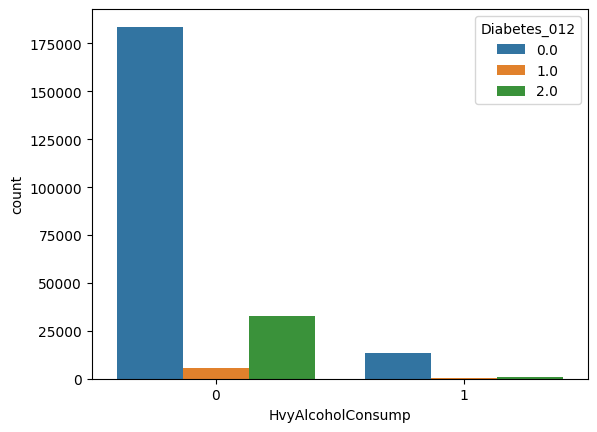

In [0]:
sns.barplot(x='HvyAlcoholConsump',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','HvyAlcoholConsump')) 

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','HvyAlcoholConsump')

5.7222551242612945e-179

Heavy Alchohol Consumtion also have impact on Diabetics

<AxesSubplot:xlabel='NoDocbcCost', ylabel='count'>

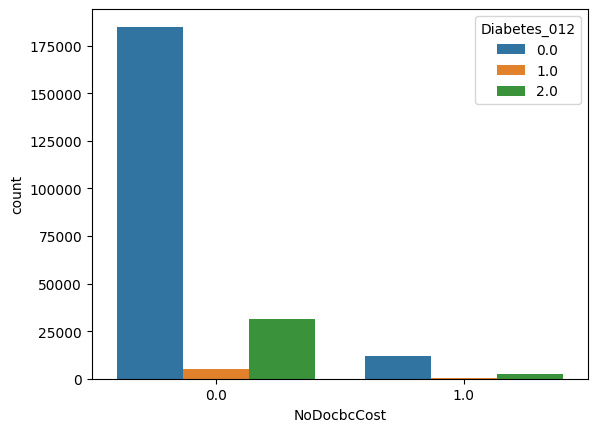

In [0]:
sns.barplot(x='NoDocbcCost',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','NoDocbcCost')) 

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','NoDocbcCost')

3.3037308046986076e-22

In [0]:
Here also p value less than 0.05. Therefore we can take Could Not Afford To See Doctor in past year also a factor of Diabeics

<AxesSubplot:xlabel='GenHlth', ylabel='count'>

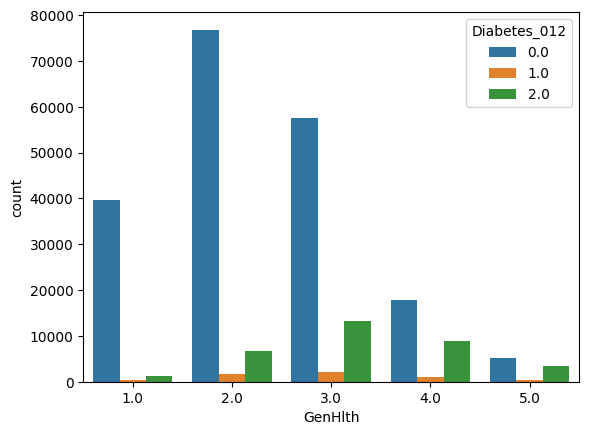

In [0]:
sns.barplot(x='GenHlth',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','GenHlth')) 

As shwon in figure when General health is decrased it (5 means poor) there is high chance to get diabetics(ratio increases)

<AxesSubplot:xlabel='Diabetes_012', ylabel='MentHlth'>

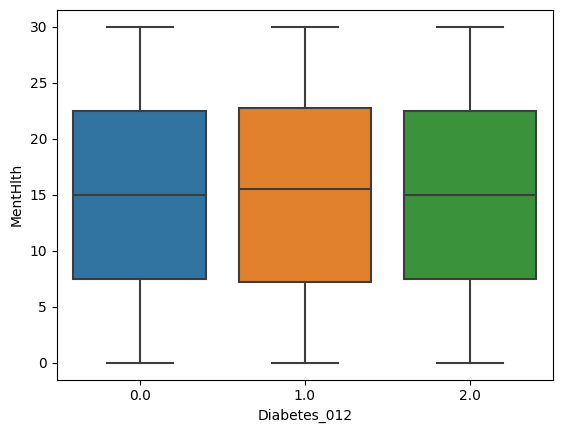

In [0]:
sns.boxplot(y='MentHlth',x='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','MentHlth')) 

There is no varation according to category. Therefore It can drop



<AxesSubplot:xlabel='Diabetes_012', ylabel='PhysHlth'>

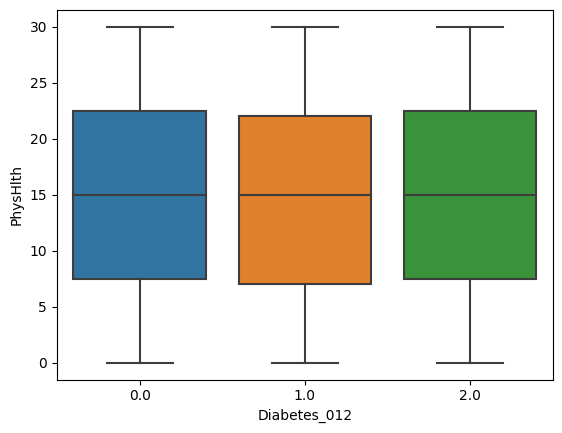

In [0]:
sns.boxplot(y='PhysHlth',x='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','PhysHlth')) 

In [0]:
No variations amoung categories

<AxesSubplot:xlabel='DiffWalk', ylabel='count'>

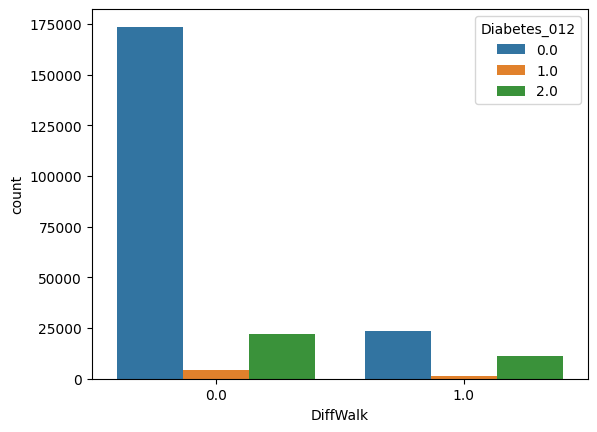

In [0]:
sns.barplot(x='DiffWalk',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','DiffWalk')) 

In [0]:
It shows fraction of People who have difficult to walk have high chance of getting diabetics

<AxesSubplot:xlabel='Sex', ylabel='count'>

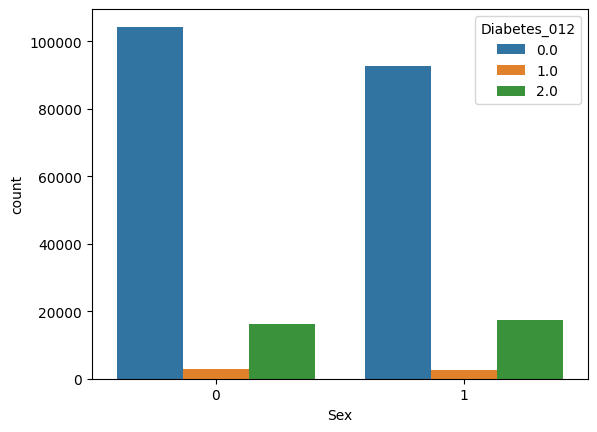

In [0]:
sns.barplot(x='Sex',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Sex')) 

Males have high risk to get diabetics

<AxesSubplot:xlabel='Age', ylabel='count'>

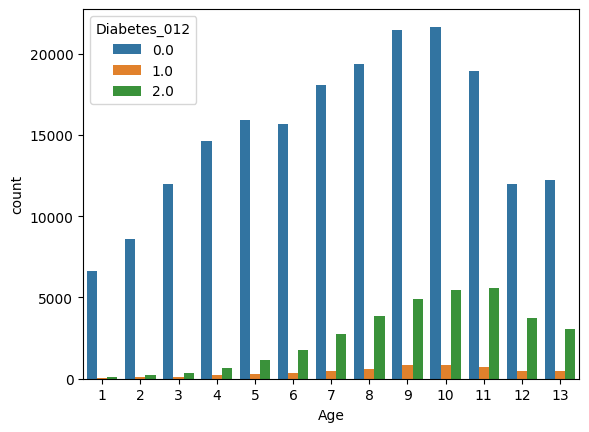

In [0]:
sns.barplot(x='Age',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Age')) 

In [0]:
chi_squared_values_sql(spark,'diabetes','Diabetes_012','Age')

0.0

In [0]:
Age has impact on diabetics. It shows after 11th category it dropped. It occured getting old means approacing to death

<AxesSubplot:xlabel='Education', ylabel='count'>

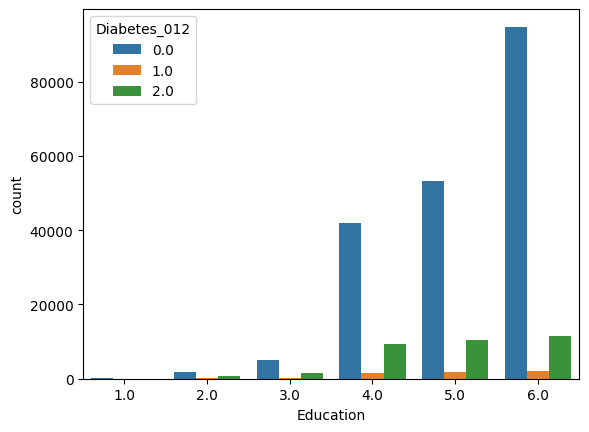

In [0]:
sns.barplot(x='Education',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Education')) 

Education level have impact on diabetics

<AxesSubplot:xlabel='Income', ylabel='count'>

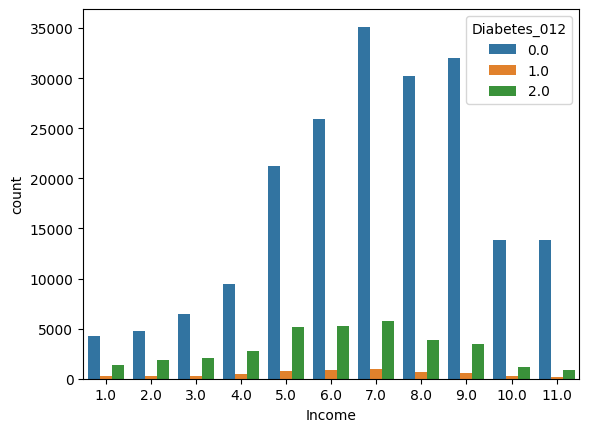

In [0]:
sns.barplot(x='Income',y='count',hue='Diabetes_012',data=col2s_count(spark,'diabetes','Diabetes_012','Income')) 

As increase income level the chance to get diabetics goes down

In [0]:
spark.stop()